In [8]:
import multiprocessing
import time
from typing import TypeVar, Hashable, Dict, List, Callable, Iterable, Tuple, Optional
import collections
import tarfile
import gzip
import itertools
import matplotlib
import praw
from urllib.parse import urlparse
from IPython.display import Image
import PIL
from PIL import Image

import nltk
from nltk.corpus import gutenberg
from nltk.corpus import stopwords

from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


from testing.testing import test

In [9]:
matplotlib.use("svg")
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import numpy as np
import torch
import os
from testing.testing import test
import string
import time
import tarfile
if not os.environ.get("DISABLE_TESTING", False):
    %matplotlib inline

In [10]:
#LIBRARIES NEEDED FOR THE 
import pandas as pd 
import numpy as np 
import torch.nn as nn
from pytorch_pretrained_bert import BertTokenizer, BertModel
import torch
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
import tqdm
from tqdm import tqdm, trange
from google.colab import files

ModuleNotFoundError: No module named 'google.colab'

In [11]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use("svg")
plt.style.use("ggplot")
import numpy as np
import torch
import os
import string
import time
import tarfile

if not os.environ.get("DISABLE_TESTING", False):
    %matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
from os import path
from PIL import Image
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
np.random.seed(500)

# Motivation
Fake news is one of the most controversial and objectively one of the most problematic issue we are facing in the 21st century. With the upcoming elections in the next year, being able to determine which types of news is crucial in order to combat the spread of misinformation. We will take a structured data science approach in order to construct a method of classification that will be able to predict whether a piece of text is determined to be real or not. We will extract data from multiple different sources that are accreddited as fake or not, then explore the data using Exploratory Data Analysis, construct and compare different prediction models when it comes to classifying fake news. 

Throughout the new advances in classification, Fake News classification has been generally been able to be solved through multiple different feature analysis regarding the dissimination of the text. We decided to take a modern approach, combining the concept of word embedding models to understand the context of text within a neural network which enables us to classify fake news more accurately. For this model, we implemented Google's BERT Model which will be explained more in the prediction section of the notebook.

Especially within the upcoming election and candidates spending more than millions on digital advertising, it is imperative that such articles be checked for accurate information so voters can be informed when making decisions.

Moreover, the overall goal for this project is to determine which are the most effective models to use when dealing with NLP problems. We are interested to see whether a model such as an SVM or a Naive Bayes would work well compared to a deep learning framework. We understand the era of fake news classification can be largely solved, thus we want to see a more efficient framework when approaching these problems.

## Outline

 1. Data Collection/Scraping
 2. Data Cleaning
 3. EDA
 4. Prediction Methods
 5. Result Analysis


## Data Collection/Scraping



Real News Website

For the sake of this scope of the project, we will assume that following websites are accurate in terms of the publication material produced by the source and are not fake news sources. 

NY Times, Reddit/r/Not the Onion and label these sources those as Real News text data. We also found that Reddit/r/TheOnion has posed as a satirical commentary that is shown to be proven as fake news since it depicts fictional stories that paint a picture but are still fundamentally fake.

Original Sources pages: https://www.nytimes.com/
Reddit Real News: https://www.reddit.com/r/nottheonion/
Reddit Fake News: https://www.reddit.com/r/TheOnion/
Fake News Website (News Punch): https://newspunch.com/

We were able to use an API for the New York Times and an API helper library for extracting the pages from the reddit screen. For the NewsPunch source, we simply scraped the website for the content.

Reddit: https://pushshift.io/api-parameters/
New York Times: https://developer.nytimes.com/

Note: No need to run any of the code since the data is already run before

## Scraping NewsPunch 
Used the BeautifulSoup library and the requests library to gather data from the newspunch library. We were able to retrieve these parts of the dataset

1. Title
2. Text
3. Date
4. Author 
5. Number of Comments

In [ ]:
response = requests.get("https://newspunch.com/category/news/us/")
soup = BeautifulSoup(response.text, 'html.parser')
link = soup.find_all('a')


In [5]:
#within each of the articles, need to find the url link
def getLinksURLFromPage(link):
    response = requests.get(link)
    soup = BeautifulSoup(response.text, 'html.parser')
    articles = soup.find_all('article')
    links = []
    for article in articles:
        links.append(article.find('a').get('href'))
    return links


"""
Input: Link main URL page (str)
Output: Number of pages for the website (int)
"""
def getNumPages(head_page_link):
    #have to find a with a class "page-numbers"
    root = requests.get(head_page_link)
    soup_text_page = BeautifulSoup(root.text, 'html.parser')
    string_page_numbers = soup_text_page.find_all("a", class_ = "page-numbers")
    links = []
    for soup_item in string_page_numbers:
        link = soup_item.get("href")
        links.append(link)

    page_numbers = []
    
    for link in tqdm(links):
        numbers = re.findall(r'[0-9]+', link)
        if(len(numbers) == 0): continue
        else:
            numPagesList = re.findall(r'[0-9]+', link)
            num_pages = numPagesList[0]
            page_numbers.append(int(num_pages))
        
    max_pages = max(page_numbers)

    return max_pages

In [6]:
# links = getLinksURL("https://newspunch.com/category/news/us/")
max_pages = getNumPages("https://newspunch.com/category/news/us")

base_url = "https://newspunch.com/category/news/us"

def get_all_articles_from_domain(base_url, num_pages):
    
    all_urls = []
    for page_num in tqdm(range(1,num_pages+1)):
        all_urls.append(base_url + "/page/" +str(page_num))
        
    content = []
    for url in tqdm(all_urls):
        list_links_page = getLinksURLFromPage(url)
        for link in list_links_page:
            content.append(get_content(link))
    return content
        
    
"""
Input: Url for an article (str)
Output: Content of the article (dictionary)
Output: Dictionary (keys: title, content, author) correspond to values(title of article , content of article , author of article) (TYPE: strs)
"""
def get_content(url_article):
    
    result_content = dict()

    
    
    request_text = requests.get(url_article).text
    content = BeautifulSoup(request_text, "html.parser")
    
    #get the title of the article
    title_article = content.find("h1", class_ = "entry-title")
    if(title_article != None): 
        result_content["title"] = title_article.get_text()
    else:
        result_content["title"] = np.nan
    
    #getting the author of the article
    author = content.find("a", class_ = "fn")
    if(author != None): 
        result_content["author"] = author.get_text()
    else:
        result_content["author"] = np.nan
        
    #getting the date of the article
    date = content.find("span", class_ = "entry-meta-date updated")
    if(date != None):
        date_result = date.find("a")
        if(date_result != None): date_result = date_result.get_text()
        result_content["date"] = date_result
    
    #get the comments
    comments = content.find("span", class_ = "entry-meta-comments")
    if(comments != None):
        comment = comments.find("a")
        num_comments = 0
        if(comment != None): num_comments = comment.get_text()
        result_content["num_comments"] = num_comments
    
    
    #get the content of the article 
    text_data = content.find('div', class_='entry-content clearfix')
    if(text_data != None):
        #find all the paragarphs with the text
        paragraphs = text_data.find_all("p")
        text = ""
        if(paragraphs != None):
            for body_data in paragraphs:
                if(body_data != None):  text += body_data.get_text()
        result_content["content"] = text
        
    
    #get the snippet of the article 
    snippet = content.find("div", class_ = "entry-content clearfix")
    if(snippet != None):
        text = snippet.find("p")
        num_comments = 0
        if(text != None): 
            data = text.find("strong")
            result = ""
            if(data != None): 
                result = data.get_text()
            result_content["snippet"] = result
    return result_content

NameError: name 'requests' is not defined

In [ ]:
url = "https://newspunch.com/category/news/us"
numPages = getNumPages(url)
article_content = get_all_articles_from_domain(url, 500)


In [ ]:
#creates a csv file from the article data
def save_data(article):
           
    titles = []
    author = []
    content = []
    snippet = []
    num_comments = []
    date = []
    label = []
    
      
    for i in tqdm(range(len(article))):
        dictionary = article[i]
        if(type(dictionary["snippet"]) != str):
            continue
            
        titles.append(dictionary["title"])
        author.append(dictionary["author"])
        content.append(dictionary["content"])
        snippet.append(dictionary["snippet"])
        date.append(dictionary["date"])
        num_comments.append(dictionary["num_comments"])
        label.append(0)
    df = pd.DataFrame({'title': titles, 'content': content, 'date': date, 'snippet': snippet, 'author': author, "number of comments": num_comments, "label": label})
    df.to_csv('FAKE_news_punch_data.csv')
#save_data(article_content)

## REDDIT Data (Real and Fake News Scraping)
We used similar process (for each reddit subpage) in order to gather the data from the subpages
Used this website: https://medium.com/@RareLoot/using-pushshifts-api-to-extract-reddit-submissions-fb517b286563

In [ ]:
import pandas as pd
import requests
import json
import csv
import time
import datetime
from psaw import PushshiftAPI


In [ ]:

def gatherDataOnion():
    # Instantiate 
    api = PushshiftAPI()

    # Create list of scraped data
    scrape_list = list(api.search_submissions(subreddit="theonion", filter=['title', 'author', 'subreddit_subscribers', 'score', 'domain', 'created_utc'],
                                limit=10000))
    result_dictionary = dict()
    title = []
    author = []
    subscribers = []
    date = []
    score = []
    domain_source = []
    
    for submission in tqdm(scrape_list,position = 0):

        original_source = submission[2]
        domain_source.append(original_source)
        
        
        title_submission = submission[5]
        title.append(title_submission)
        
        author_submission = submission[0]
        author.append(author_submission)
        
        
        
        subscriber_submission = submission[4]
        subscribers.append(subscriber_submission)
                
        date_created = submission[1]
        date.append(date_created)
        
        
        score_submission = submission[3]
        score.append(score_submission)
        
        
    label = [0] * len(title)
    df = pd.DataFrame({'title': title, 'author': author, 'date': date, 'score': score, 'subscribers':subscribers,'source':domain_source, 'label': label })
    df.to_csv('better_fake_onion.csv')




In [ ]:

def gatherDataReal():
    # Instantiate 
    api = PushshiftAPI()

    # Create list of scraped data
    scrape_list = list(api.search_submissions(subreddit="nottheonion", filter=['title', 'author', 'subreddit_subscribers', 'score', 'domain', 'created_utc'],
                                limit=20000))
    print(scrape_list[0])
    result_dictionary = dict()
    title = []
    author = []
    subscribers = []
    date = []
    score = []
    domain_source = []
    
    for submission in tqdm(scrape_list,position = 0):

        original_source = submission[2]
        domain_source.append(original_source)
        
        
        title_submission = submission[5]
        title.append(title_submission)
        
        author_submission = submission[0]
        author.append(author_submission)
        
        
        
        subscriber_submission = submission[4]
        subscribers.append(subscriber_submission)
                
        date_created = submission[1]
        date.append(date_created)
        
        
        score_submission = submission[3]
        score.append(score_submission)
        
    label = [1] * len(title)
    
    df = pd.DataFrame({'title': title, 'author': author, 'date': date, 'score': score, 'subscribers':subscribers,'source':domain_source, 'label': label })
    df.dropna()
    df.to_csv('real_onion_good.csv')




## New York Times Data Collection

In the code block that follows, we scrape a chunk of 2000 articles (as that was the max results found) from the New York Times about politics (involving President Trump) using their propietary API calls for Python. We narrowed our query from January 1, 2015 - Present to keep our data of political relevance. Furthermore, in the actual data scraping, we wanted to take the data, and extract it into 5 columns:
1. Label (1 for real news, 0 for fake news)
2. Title (title of the article)
3. Summary (NYT API doesn't actually give back the full corpus of the article, only the abstract which is enough)
4. Date (Date published)
5. Author (Name of author who published it, or "NO AUTHOR FOUND" if not found by the API

For the NYT data, the label was always '1' since we can classify this data as "Real News."

Now, to scrape the data, we first created a helper function called "getTenArticles" which gets a response of 10 articles from New York Times (as that is all that is allowed per request) using an API key that we got from an account we created, used the "search" function to query articles from 2015 onwards with "Trump" in it.

The response from the API was given as a List[List[Dictionaries]] so, we had to go through this data structure to extract all 5 column information from each article, and return a list of dictionaries, where each dictionary corresponded to each article.

Next, we had to extract all 2000 articles of from NYT, but the NYT API restricts you to only making an API request every ~6 seconds, so we had to loop through and create a pause of 6 seconds per each 10 article request. (This ended up taking a bit of time to run, consequently.)

Finally, once we had extracted all the 2000 articles as a list of list of dictionaries, we were able to simply create another helper function "convertToPandas" to get each dictionaries (where each dictionary was an article) information and convert it to a list of lists. 

Once this information was finally cleaned and saved, we were able to make use of Pandas' "df.to_csv" function to save it as a processed and cleaned CSV file.

## NOTE: DO NOT RUN THE NEXT CODE BLOCK AS IT WOULD TAKE QUITE A LONG TIME TO RUN, ALL THE DATA THAT WAS PROCESSED WAS ALREADY SAVED AND USED IN LATER CODE BLOCKS

In [ ]:
#Our api key
api = articleAPI('Ik7gleUxf7QQNG2OjDemKh0oSKlG40RW')

#Learned syntax and methods to extract NYT data from online
#But wrote all code on our own
#Link is below
def getTenArticles(pageNum):    
    articles = api.search(q = 'trump',page = pageNum, begin_date=20150101)
    articleResponse = articles["response"]["docs"]
    listOfArticles = []
    for article in articleResponse:
        eachArticle = dict()
        eachArticle["label"] = 1
        eachArticle["title"] = article['headline']['main']
        eachArticle["summary"] = article['abstract']
        posOfSecond = str(article["pub_date"]).index("T")
        eachArticle["date"] = article["pub_date"][0:posOfSecond]
        if(article["byline"]["person"] != []):
            firstName = article["byline"]["person"][0]["firstname"]
            lastName = article["byline"]["person"][0]["lastname"]
            name = ""
            if(firstName != None):
                name += firstName
            if(lastName != None):
                name += " " + lastName
            eachArticle["author"] = name
        else:
            eachArticle["author"] = "NO AUTHOR FOUND"
        listOfArticles += [eachArticle]
    return listOfArticles
allArticles = []
for num in range(200):
    allArticles += getTenArticles(num)
    time.sleep(6)
newList = []
for article in allArticles:
    tempList = []
    tempList += [int(article["label"])]
    tempList += [str(article["title"]).lower()]
    tempList += [str(article["summary"]).lower()]
    tempList += [article["date"]]
    tempList += [str(article["author"]).lower()]
    newList += [tempList]
df = pd.DataFrame(newList, columns = ['Label', 'Title', "Summary","Date", "Author"])
df.head()
export_csv = df.to_csv (r'/Users/virajpuri/Downloads/newYorkTimes.csv', index = None, header=True)    

Fake News Websites
Onion, reddit/r/The Onion
Huzler


## Data Cleaning

The features that we are going to use throughout the data pipeline process are the 

1. Title of the article
2. Content of the article
3. Data/Time/Location Published
4. Label 
5. Author


For the labels we will treat the Fake News articles as integers: 1 and the Real News articles will be 0
The other aspects of the model will be used as features for the prediction classification models. 

Throughout the overall process of conducting the analysis, we did our own Data Cleaning which mean to organize the main dataframes through the key information that we needed to perform for each dataset. For example, for the New York Times data set, we were able to get the Text, Date, Author and Label of whether or not the source of the text is Real or Not. 

The common themes throughout the Data Cleaning for text processing stayed consistent throughout the process. For example, we had to remove stopwords in order to get accurate readings for the word cloud as well as lemmatize the text for the SVM and Naive Bayes classifier. However, we decided to keep the stopwords for the deep learning model since the deep learning model is driven by context analysis thus it is important to keep as many words as possible to get the most accurate readings.

# EDA

For our Exploratory Data Analysis, we were heavily focused on the content within each text article as well as the overall sentiment towards a piece of text. We thought that there must be a certain relationship between the content of the article and the sentiment toward the article. Focusing on that, we also were interested to see the relationship between the number of fake news article published during the year.

## Word Cloud



Next, we decided to visualize the most frequent words in both the fake news data as well as the real news data. In doing so, we were able to make use of the WordCloud library function. 

We created a helper function that would take in file path to the data source, the name of the column which contains all the strings of the text data, as well as the file name of the png file you would like to save it as.

First, we began by creating a set of stopwords which included the most common stopwords in the English language, as well as any words we thought would be biased in the word cloud (for example the word "Trump" as our NYT query was for Trump and would undoubtedly be the most popular word shown), as well as any other impractical political words.
Then, we went through each element of the corpus column to create one giant string from the entire dataframe and then pass it in to the WordCloud function to visualize it, then save it as a png file.

From the results of our wordcloud, it seems that while both the fake and real news word clouds may appear similar, some subtle differences are to be noted:
    
The first word cloud (fake news) contains words that invoke more controversial topics such as 'clinton', 'fbi', or 'twitter,' whereas the second word cloud (real news) displayed more standard informational words such as 'campaign', 'nominee', or 'republican.' 

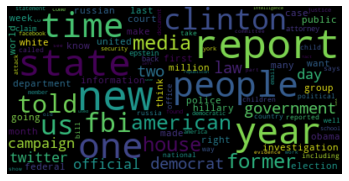

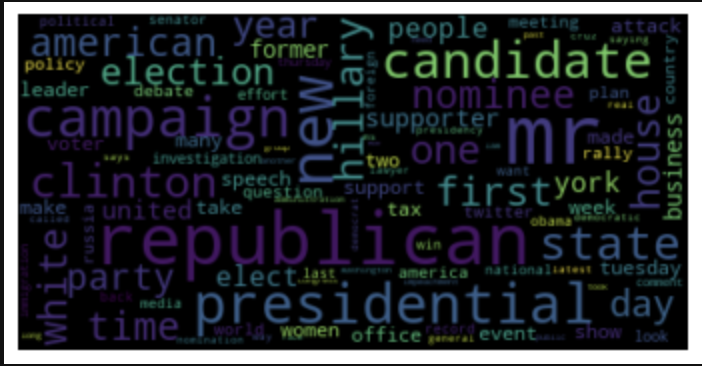

In [39]:
#Learned basic way of creating wordcloud syntax from online
#Link is at end of report
def wordCloudOfFile(filename,columnToGet,fileToSave):
    stopwords2 = set(STOPWORDS).union(set(stopwords.words('english')))
    stopwords2 = stopwords2.union(set(["said","say","according","may","even","trump","Trump","donald","president"]))
    df = pd.read_csv(filename, index_col=0)
    text = ""
    for review in df[columnToGet]:
        text += str(review).lower()
        text += " "
    wordcloud = WordCloud(collocations=False,stopwords=stopwords2,max_font_size=50, max_words=100).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig(fileToSave, format="png")
    plt.show()

wordCloudOfFile("FAKE_news_punch_data.csv", "content","FakeNewsWordCloud.png")
#wordCloudOfFile("export_dataframe.csv","Summary", "RealNewsWordCloud.png")
from IPython.display import Image
Image(filename='word_cloud.png') 


Next, we created a histogram to display the frequency of both Real News and Fake News articles in each month in a given year to investigate any interesting trends we may find. The results were quite fascinating.

We accomplished this by first setting our "Date" column in our scraped CSV file from a string column to an actual DateTime column that Pandas prefers. Once we did that, we were able to group our data frame by month, then get the count of each of the 12 groups (for each month in the year), then finally plot it with the apropriate matplot lib commands to create a bar graph. 

If one looks at the trend of the Real News articles, we find a multimodal distribution with peaks scattered throughout various months in the year, with no apparent trend (which is exactly what one would expect from a real news article, as news should be generally random with no trend.

However, looking at the histogram of the fake news articles, we find a significantly strong skew left, with the months of September, October, and November being the most popular (with October, the month before election day, being the most frequent). This could lead to one to wonder some potential reasons for this trend. One strong theory could be fake news articles produce much more content when it comes to election time, as that is when "hype" is strongest, controversy is most apparent, and people are more curious then ever about the future of their country. But, such a conclusion would require further study.  

In [41]:
def histogramOfData(filename, title, fileToSave):
    df = pd.read_csv(filename, index_col=0)
    df["Date"] = df["Date"].astype("datetime64")
    plt.figure(figsize=(27, 15))
    ax = df.groupby(df["Date"].dt.month).count().plot(kind="bar")
    ax.set_xlabel("Month")
    ax.set_ylabel("Number of articles mentioned")
    ax.set_title(title)
    ax.get_legend().remove()
    #plt.show()
    plt.savefig(fileToSave)

#histogramOfData("export_dataframe.csv", "Frequency of Real News Articles per Month","RealNewsHist.png")
#histogramOfData("FAKE_news_punch_data.csv", "Frequency of Fake News Articles per Month","FakeNewsHist.png")


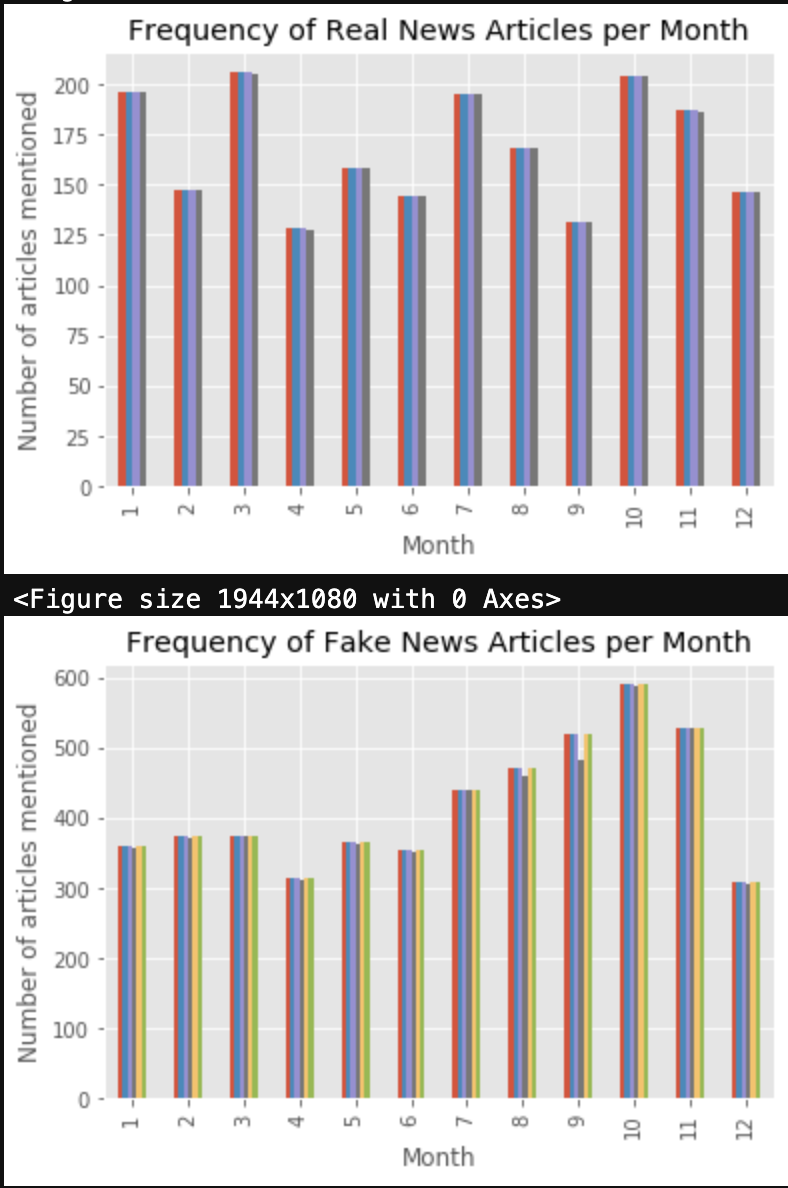

In [42]:
from IPython.display import Image
Image(filename='histogram_pics.png')

## Sent Analysis

We were also interested in the overall sentiment toward fake news and real news articles. We used the textblob library to accomplish a simple sentiment analysis toward articles. https://textblob.readthedocs.io/en/dev/

In [ ]:
from textblob import TextBlob
import matplotlib.dates as mdates


In [ ]:
time = list(dataframe_onion['timestamp'])
#Y AXIS (sent analysis)
title_list = dataframe_onion["title"]
sentimentAxis = []
for i in tqdm(range(len(dataframe_onion["title"])), position = 0):
    text = title_list[i]
    analysis = TextBlob(text)
    sentiment = analysis.sentiment
    sentimentAxis.append(sentiment)

In [ ]:
#REAL NEWS DATASET
time_real = list(dataframe_onion_real['timestamp'])
title_list = dataframe_onion_real["title"]
sentimentAxisReal = []
for i in tqdm(range(len(dataframe_onion_real["title"])), position = 0):
    text = title_list[i]
    analysis = TextBlob(text)
    sentiment = analysis.sentiment
    sentimentAxisReal.append(sentiment)
    
plt.plot(time_real,sentimentAxisReal)
# beautify the x-labels
plt.gcf().autofmt_xdate()
myFmt = mdates.DateFormatter('%D:%Y')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.title('Real News Sentiment Analysis Over Time')


In [ ]:
plt.plot(time,sentimentAxis)

# beautify the x-labels
plt.gcf().autofmt_xdate()
myFmt = mdates.DateFormatter('%D:%Y')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.title('Fake News Sentiment Analysis Over Time')


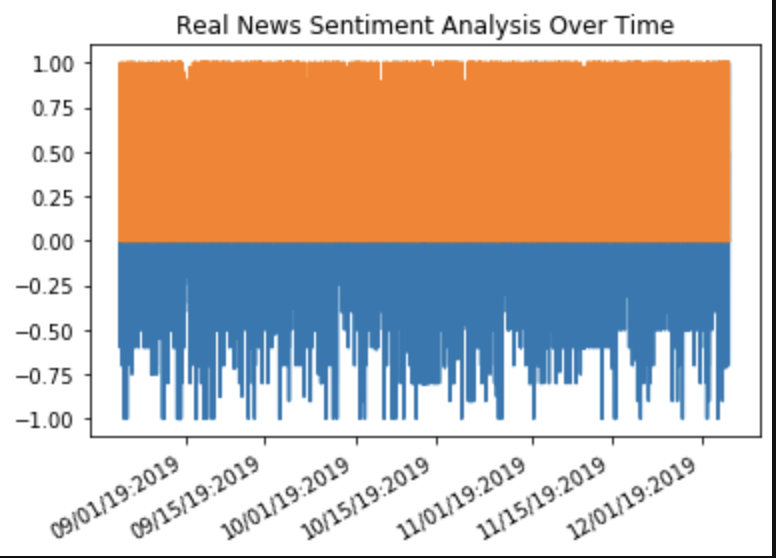

In [16]:
from IPython.display import Image


Image(filename='sent_time_text.png')


Through this visual analysis, we see that the overall sentiment toward real news is largely more positive than negative. However, this acis is from after October through December for this time of the year which shows that there are multiple spikes that show negative sentiment toward specific real news and this could be a result of trump supporters showing resentment toward a anti-trump article. 

# Prediction

## Additional Data Cleaning before Prediction

In [19]:
#HAVE TO CREATE A DATAFRAME THAT HAS A COMBINATION OF BOTH DATA
frames = [data_frameRealOnion,data_fakeOnion]

bigDataOnion = pd.concat(frames)
bigDataOnion = bigDataOnion.sample(frac=1).reset_index(drop=True)


In [20]:
data_length = len(bigDataOnion)
train_data_text = bigDataOnion[:80]
test_data_text = bigDataOnion[41:81]

## Classification Begins

Most of Fake News Classification that we have researched on the internet uses SVM models (and TFIDF's as features) in order to predict whether or not the text data is Fake News or Not. However, we also wanted to take a deep learning approach to the problem at hand. Since deep learning is largely the backbone of the latest NLP research, we wanted to test a deep learning model onto our dataset. We thought that using word vectors as features would serve a better purpose for the model to understand the context of words within an article. Using a LSTM based framework from Google called the BERT model, we were able to classify at a high accuracy rate, whether or not articles are fake news are not, not using many articles as training data. The BERT model architecture is used for Google Search queries thus its sole purpose to get high accuracy ratings with small text data.

Paper: https://arxiv.org/pdf/1810.04805.pdf
Github Research Page: https://github.com/google-research/bert

At a high level, BERT uses a transformer mechanism which is able to build a language model that is then used to classify the text. Regular transformers (directional models) reads text sequentially from left to right, however the transformer reads the text all as once, thus it allows the model to learn the context of a word based on its surroundings.

We also used a medium article(last link in attributions) to help guide us through how to use the BERT model (such as loading the data into the classifier then testing on the prediction dataset). We used our own dataset for the model and learned the syntax/notation of the model

DISCLAIMER: I had to use google colab for the training data since it was computational too intense for the computer, thus you will not be able to run the code. I have attached the results of the program and displayed them as the output

In [ ]:
import pandas as pd 
import numpy as np 
import torch.nn as nn
from pytorch_pretrained_bert import BertTokenizer, BertModel
import torch
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
import tqdm
from tqdm import tqdm, trange
from google.colab import files




uploaded = files.upload()
data_frameRealOnion = pd.read_csv('REALnyt.csv')
data_frameRealOnion = data_frameRealOnion[:2000]


data_frameRealOnion.rename(columns={"Summary": "snippet"}, inplace = True)


uploaded = files.upload()
data_fakeOnion = pd.read_csv('FAKE_news_punch_data.csv')
data_fakeOnion = data_fakeOnion[:2000]


data_fakeOnion.dropna(inplace = True)
data_frameRealOnion.dropna(inplace = True)

#add a label to the data
label = [0]*len(data_frameRealOnion)
data_fakeOnion["label"] = label

In [ ]:
#HAVE TO CREATE A DATAFRAME THAT HAS A COMBINATION OF BOTH DATA
frames = [data_frameRealOnion,data_fakeOnion]

#data_fakeOnion.head()
bigDataOnion = pd.concat(frames)
#shuffling the dataframe
bigDataOnion = bigDataOnion.sample(frac=1).reset_index(drop=True)

In [ ]:
#70%: Train, 30%: Test
data_length = len(bigDataOnion)
train_data_text = bigDataOnion[:1398]
test_data_text = bigDataOnion[1398:1997]


In [ ]:
#FUNCTION that Bert Tokenizer function


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


In [ ]:
train_data = []
for index_label in range(len(list(train_data_text['label']))):
    label = list(train_data_text['label'])[index_label]
    text = list(train_data_text['title'])[index_label]
    dictionary = {'title': text, 'label': label}
    train_data.append(dictionary)



test_data = []
for index_label in range(len(list(test_data_text['label']))):
    label = list(test_data_text['label'])[index_label]
    text = list(test_data_text['title'])[index_label]
    dictionary = {'title': text, 'label': label}
    test_data.append(dictionary)

In [ ]:
#Extracting the text/labek data for the training data and the test data 
train_texts, train_labels = list(zip(*map(lambda bigDataOnion: (bigDataOnion['title'], bigDataOnion['label']), train_data)))
test_texts, test_labels = list(zip(*map(lambda bigDataOnion: (bigDataOnion['title'], bigDataOnion['label']), test_data)))

In [ ]:
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:511], train_texts))
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:511], test_texts))

In [ ]:
#prepping the data through creating the token ID's
train_tokens_ids = pad_sequences(train_tokens_ids, maxlen=512, truncating="post", padding="post", dtype="int")
test_tokens_ids = pad_sequences(test_tokens_ids, maxlen=512, truncating="post", padding="post", dtype="int")

In [ ]:
#TRUE IS FAKE NEWS which is what the model will use when calculating the loss of the classifier

train_y = np.array(train_labels) == 0
test_y = np.array(test_labels) == 0

In [3]:
## BERT Classifier
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, tokens, masks=None):
        _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        proba = self.sigmoid(linear_output)


NameError: name 'nn' is not defined

In [ ]:
#masking the train and test data through torch tensors

train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]
train_masks_tensor = torch.tensor(train_masks)
test_masks_tensor = torch.tensor(test_masks)

In [ ]:
#Tokenizing the tensors from the training/test data

train_tokens_tensor = torch.tensor(train_tokens_ids)
train_y_tensor = torch.tensor(train_y.reshape(-1, 1)).float()
test_tokens_tensor = torch.tensor(test_tokens_ids)
test_y_tensor = torch.tensor(test_y.reshape(-1, 1)).float()

In [ ]:
#organizing the data so that it is batched into datasets, samplers, and the dataloader for the training/test data set
BATCH_SIZE = 1
EPOCHS = 1
train_dataset =  torch.utils.data.TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_sampler =  torch.utils.data.RandomSampler(train_dataset)
#the dataloader simply is the process that will be inputted into the model
train_dataloader =  torch.utils.data.DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)
test_dataset =  torch.utils.data.TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
test_sampler =  torch.utils.data.SequentialSampler(test_dataset)
test_dataloader =  torch.utils.data.DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

In [ ]:
#TRAINING LOOP
#The model/training loop was based off the paper from the BERT paper and a combination of combining different methods 
#for deep learning classification models
bert_clf = BertBinaryClassifier()
optimizer = torch.optim.Adam(bert_clf.parameters(), lr=3e-6)
for epoch_num in tqdm(range(EPOCHS)):
    bert_clf.train()
    train_loss = 0
    for step_num, batch_data in enumerate(train_dataloader):
        token_ids, masks, labels = tuple(t for t in batch_data)
        probas = bert_clf(token_ids, masks)
        loss_func = nn.BCELoss()
        batch_loss = loss_func(probas, labels)
        train_loss += batch_loss.item()
        bert_clf.zero_grad()
        batch_loss.backward()
        optimizer.step()
        print('Epoch: ', epoch_num + 1)
        print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_data) / BATCH_SIZE, train_loss / (step_num + 1)))


In [6]:
#Prediction 
bert_clf.eval()
bert_predicted = []
all_logits = []

#while there isnt anymore data within the torch tensored train set, we calculate the loss for each of the predictions with the MOdel
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):
        token_ids, masks, labels = tuple(t for t in batch_data)
        logits = bert_clf(token_ids, masks)
        loss_func = nn.BCELoss()
        loss = loss_func(logits, labels)
        numpy_logits = logits.cpu().detach().numpy()
        
        bert_predicted += list(numpy_logits[:, 0] > 0.5)
        all_logits += list(numpy_logits[:, 0])
        
print(classification_report(test_y, bert_predicted))

After training the model on only 40 articles, we were able to get very good results. Of the 22 articles that were Fake News, we got 68% of the articles correctly classfied, and of the 18 articles that were Fake News, we got 61% of the articles classifed as Real News

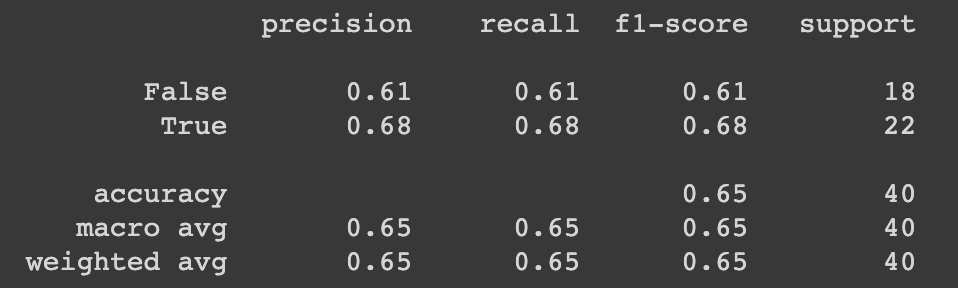

In [45]:
Image(filename='1_epoch_40Articles.png')


After training the model for 1500 articles and only 1 epoch, we were able to get very good results, with a 81% precision rate for determining whether the set of articles were true, and a 89% percent accuracy rate determining if the Fake articles are Fake News. Note this is not a confusion matrix, this is a classification report

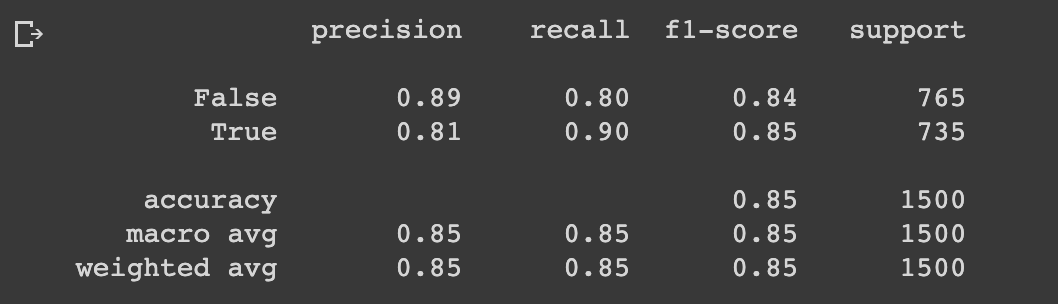

In [38]:
## Getting The Results for the BERT Model
from IPython.display import Image
Image(filename='1500_article.png')


We clearly see that using a deep learning approach to this classification problem clearly makes it better for classifier's to operate with less amount of data. This framework of using word vectors as feature is alot more effective since the model is able to interpret the effect of a word based on its context within an article. We will see how with more training data, the SVM and the Naive Bayes classifiers will work well, However there should be a clear consensus that the deep learning approach is alot more efficient given the less amount of data.

## SVM and Naive Bayes

First, we created a helper function "loadInitNews" which reads in the real news CSV file and the fake news CSV file, then joins them together, and finally shuffles them around so as to keep our results as accurate as possible.

Next, we seek to classify whether an article is fake or real from the title of the article, so we take the title column, and give it back as a lower case, tokenized version, so as to ensure that the text data is all treated equally (i.e "Happy" == "happy").

Next we have a helper function that actually does the brunt of the processing and lemmatizing.
Here, in the "processWords" helper function, we first create a dictionary of word POS tags for Nouns, Adjectives, Verbs, and Adverbs. Then we can go through each row of the Real+Fake news dataframe (each article), and then go through each word in the processed version of the title of that article and and create a new column of the lemmatized, non-stopword version of the words in the pre-processed title. Essentially, passing it through another filter to additionally process it. 

#### NOTE: DO NOT RUN THE NEXT CODE BLOCK AS IT TAKES ABOUT 3 MINUTES TO RUN, WE HAVE ALREADY RUN IT AND SAVED THE DATA AS "classifyFakeOrReal.csv"

In [17]:
#Learned how to clean the text data from article on classification,
#But wrote all this code on my own
#Link is at end of article
def loadInitNews(realNewsFile, fakeNewsFile):
    corpusReal = pd.read_csv(realNewsFile)
    corpusReal.reset_index(drop=True)
    corpusFake = pd.read_csv(fakeNewsFile)
    corpusFake.reset_index(drop=True)
    Corpus = pd.concat([corpusReal,corpusFake], ignore_index=True)
    Corpus = Corpus.sample(frac=1).reset_index(drop=True)
    Corpus.drop_duplicates(keep = False, inplace = True)
    lowerList = []
    for text in Corpus["title"]:
        lowerList += [word_tokenize(text.lower())]
    Corpus['title']= lowerList
    return Corpus

#Got this processing and lemmatizing information from: 
#Classification of text data article online, link is at the end of this report
def processNews(allNews):
    tag_map = defaultdict(lambda : wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV
    for index,entry in enumerate(allNews['title']):
        Final_words = []
        word_Lemmatized = WordNetLemmatizer()
        for word, tag in pos_tag(entry):
            if word not in stopwords.words('english') and word.isalpha():
                word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
                Final_words.append(word_Final)
        allNews.loc[index,'processedText'] = str(Final_words)
    return allNews

allNews = loadInitNews("real_onion_good.csv","better_fake_onion.csv")
newsFinal = processNews(allNews)
export_csv = newsFinal.to_csv (r'/Users/virajpuri/Downloads/classifyFakeOrReal.csv', index = None, header=True)    

In [18]:
#Learned TDIDF syntax from article on classification
#Link at bottom
newsData = pd.read_csv("classifyFakeOrReal.csv")
trainFeatures, testFeatures, trainLabels, testLabels = model_selection.train_test_split(newsData['processedText'],newsData['label'],test_size=0.4)
Tfidf_vect = TfidfVectorizer(max_features=2000)
Tfidf_vect.fit(newsFinal['processedText'])
Train_X_Tfidf = Tfidf_vect.transform(trainFeatures)
Test_X_Tfidf = Tfidf_vect.transform(testFeatures)

To classify, we first used a Naive Bayes, as it was almost instant to run, thanks to its "Naivety," and could quickly classify the test data we had set aside. Our classifier did extremely well, predicting the label of our set aside test data at a rate of almost 80%, which is incredible. 

Some possible ways that could improve this accuracy in the future would be to potentially increase the number of features (as seen above as a hyperparameter, at the expense of speed), or to play around with the different types of Naive Bayes models (i.e here we used a multinomial Naive Bayes), or play around with the alpha hyperparameter (the smoothing parameter). We also could have increased the percent of data set aside for training data.

In [ ]:
#Learned about naive bayes library and played around with parameters 
#From scikit learn API, linked at end of report
nbClassifier = naive_bayes.MultinomialNB(alpha=3.0, fit_prior=False)
nbClassifier.fit(Train_X_Tfidf,trainLabels)
yHat = nbClassifier.predict(Test_X_Tfidf)
print("Accuracy of Naive Bayes: " + str(accuracy_score(yHat,testLabels) * 100) + "%")

Lastly, we used an SVM with a linear kernel to classify the text data as well (as SVMs work extremely well for linearly separable data, especially binary classification), and noticed something interesting:

While it did quite well (at over 80% accuracy), it ran considerably slower (took almost a minute) compared to the Naive Bayes model (which ran near instantly). 

This leads us to conclude that while the SVM did somewhat better than the Naive Bayes, due to the instantaneous run speed of the Naive Bayes, we would prefer that model to classify the text data. 

## Note: The next code block takes about 20 seconds to run

In [ ]:
SVM = svm.SVC(kernel='linear')
SVM.fit(Train_X_Tfidf,trainLabels)
predictions_SVM = SVM.predict(Test_X_Tfidf)
print("Accuracy of SVM: " + str(accuracy_score(predictions_SVM,testLabels) * 100) + "%")

# Results

The SVM and Naive Bayes classifier methods did quite well regarding the large number of articles that were being fed into the model. We do however, see a clear better option for classifiying text data which was the deep learning approach to dealing with text data. The BERT model is much more effective since it uses less data and reads the text to find context analysis since the features are word vectors. Thus we see why deep learning is a much more practical way of dealing with NLP approaches.

### Attributions:
Learned syntax for scraping data from NYT API from (but wrote all code on our own):
https://dlab.berkeley.edu/blog/scraping-new-york-times-articles-python-tutorial

Learned how to create wordcloud from:
https://www.datacamp.com/community/tutorials/wordcloud-python

Got text processing code for "processNews" from:
https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34

Learned TFIDF syntax to organize and create features of data from:
https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34

Learned about Naive Bayes classifier syntax from: 
https://scikit-learn.org/stable/modules/classes.html#module-sklearn.naive_bayes

Learned about SVM classifier syntax from:
https://scikit-learn.org/stable/modules/svm.html

Learned syntax for the BERT model from (but wrote all code on our own):
https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270
https://medium.com/huggingface/multi-label-text-classification-using-bert-the-mighty-transformer-69714fa3fb3d
